In [1]:
import pandas as pd
import pydicom
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
import os
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the CSV file
df = pd.read_csv('RSNA_breast_cancer_data.csv')

In [2]:
# Function to load DICOM images and resize them
def load_dicom_image(image_path, target_size=(224, 224)):  # Resize to 224x224 for ResNet101
    dicom = pydicom.dcmread(image_path)
    image = dicom.pixel_array
    image_resized = cv2.resize(image, target_size)
    image_normalized = image_resized / np.max(image_resized)  # Normalize pixel values
    
    # Convert grayscale to 3 channels by replicating the grayscale image
    image_rgb = np.stack([image_normalized] * 3, axis=-1)  # Replicate across 3 channels
    return image_rgb

# Load all the images and labels
image_paths = df['image_path'].values
labels = df['cancer'].values

In [3]:
# Prepare data
images = []
for path in image_paths:
    image = load_dicom_image(path)  # Directly use the full path from the CSV
    images.append(image)

images = np.array(images)
labels = np.array(labels)

In [6]:
images.shape

(2374, 224, 224, 3)

In [ ]:
# Load ResNet101 for feature extraction, without the final classification layer
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = True

# Create a new model for feature extraction
feature_extractor = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pool the extracted features
    Flatten()  # Flatten the features to a 1D vector
])

# Extract features from the entire dataset
features = feature_extractor.predict(images)

75/75 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step


In [8]:
from sklearn.svm import SVC
# Now split the extracted features into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [9]:
## Finding best parameters
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)
print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': np.float64(1.0), 'gamma': np.float64(1.0)} with a score of 0.67


In [19]:
classifier = SVC(kernel='linear',C= 1.0, gamma= 1.0)
classifier.fit(X_train, y_train)
y_test_pred = classifier.predict(X_test)

In [20]:
print(f"y test {y_test.shape}, y pred {y_test_pred.shape}")

y test (475,), y pred (475,)


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the test set
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.67      0.61      0.64       247
           1       0.62      0.68      0.65       228

    accuracy                           0.64       475
   macro avg       0.64      0.64      0.64       475
weighted avg       0.65      0.64      0.64       475



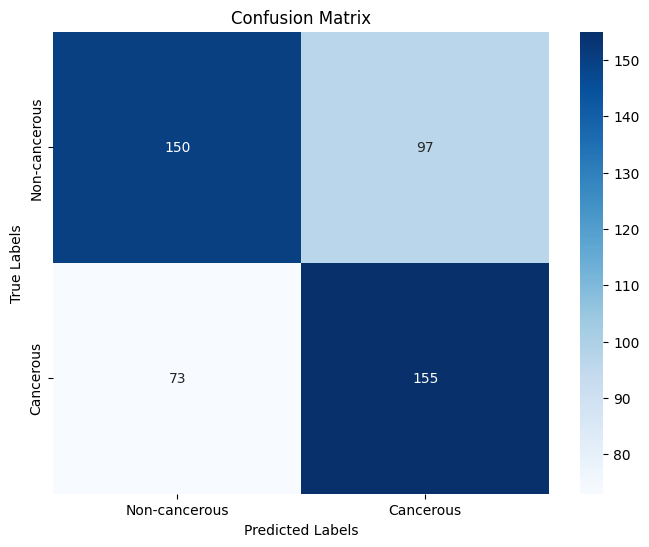

In [22]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-cancerous', 'Cancerous'], yticklabels=['Non-cancerous', 'Cancerous'])
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

## RF

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier with default parameters
classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust n_estimators and other params

# Train the classifier
classifier.fit(X_train, y_train)

# Predict on the test set
y_test_pred = classifier.predict(X_test)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the test set
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.67      0.77      0.72       247
           1       0.70      0.58      0.63       228

    accuracy                           0.68       475
   macro avg       0.68      0.68      0.67       475
weighted avg       0.68      0.68      0.68       475



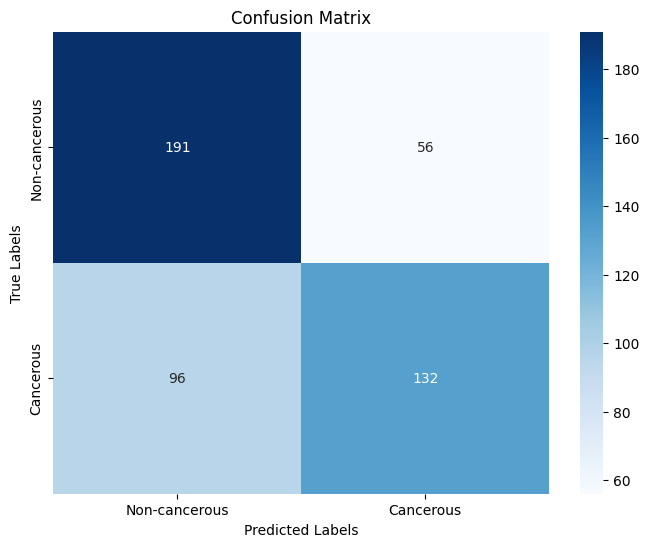

In [18]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-cancerous', 'Cancerous'], yticklabels=['Non-cancerous', 'Cancerous'])
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

## INTRODUCE LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Step 1: Perform LDA for dimensionality reduction
lda = LDA(n_components=1)  
features_lda = lda.fit_transform(features, labels)

# Step 2: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_lda, labels, test_size=0.2, random_state=42)

# Step 3: Train the SVM classifier on the reduced features
svm_classifier = SVC(kernel='rbf', C=1.0, gamma=1.0)  # You can adjust the parameters as needed
svm_classifier.fit(X_train, y_train)

SVC(gamma=1.0)

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_test_pred = svm_classifier.predict(X_test)

# Evaluate the model on the test set
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87       247
           1       0.85      0.86      0.86       228

    accuracy                           0.86       475
   macro avg       0.86      0.86      0.86       475
weighted avg       0.86      0.86      0.86       475



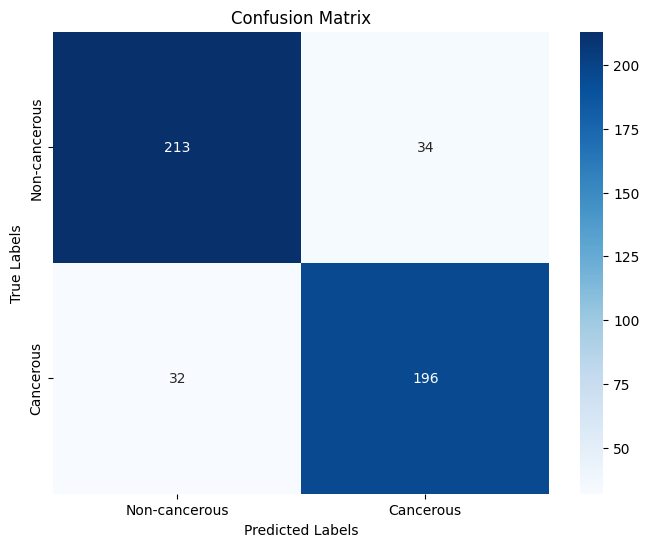

In [26]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-cancerous', 'Cancerous'], yticklabels=['Non-cancerous', 'Cancerous'])
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

## **ABOVE** -
### This is wrong, because, test data was seen in lda process by the training process

## LDA after splitting

In [40]:
# Step 1: Split the dataset into training and test sets first
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Step 2: Apply LDA (or other transformation) only on the training data
lda = LDA()
X_train_lda = lda.fit_transform(X_train, y_train)  # Fit and transform the training data

# Step 3: Transform the test data using the same LDA transformation (no fitting here)
X_test_lda = lda.transform(X_test)  # Only transform the test data

# Step 4: Train the SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0, gamma='scale')
svm_classifier.fit(X_train_lda, y_train)

SVC(kernel='linear')

In [42]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_test_pred = svm_classifier.predict(X_test_lda)

# Evaluate the model on the test set
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.64      0.56      0.60       247
           1       0.58      0.66      0.62       228

    accuracy                           0.61       475
   macro avg       0.61      0.61      0.61       475
weighted avg       0.61      0.61      0.61       475



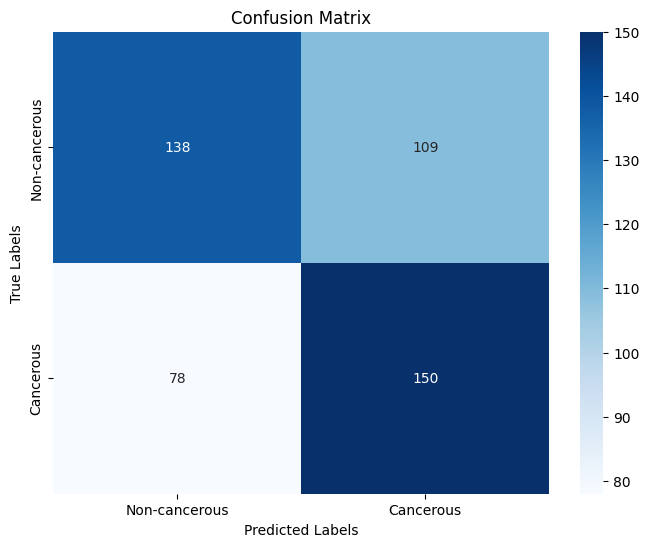

In [43]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-cancerous', 'Cancerous'], yticklabels=['Non-cancerous', 'Cancerous'])
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

## Introducing PCA

In [37]:
from sklearn.decomposition import PCA

# Step 1: Perform PCA for dimensionality reduction
pca = PCA(n_components=50)  # Choose the number of components (adjust based on your dataset)
features_pca = pca.fit_transform(features)

# Step 2: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.2, random_state=42)

# Step 3: Train the SVM classifier on the reduced features
svm_classifier = SVC(kernel='linear', C=1.0, gamma='scale')  # You can adjust the parameters as needed
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_test_pred = svm_classifier.predict(X_test)

# Evaluate the model on the test set
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.68      0.64      0.66       247
           1       0.63      0.67      0.65       228

    accuracy                           0.65       475
   macro avg       0.65      0.65      0.65       475
weighted avg       0.65      0.65      0.65       475



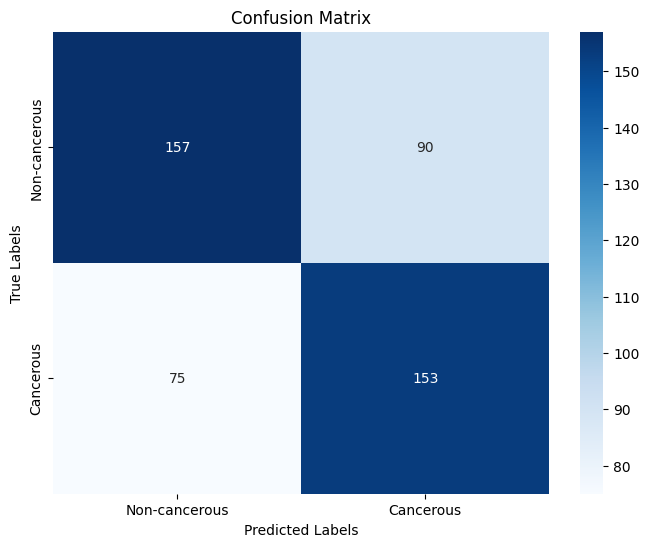

In [39]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-cancerous', 'Cancerous'], yticklabels=['Non-cancerous', 'Cancerous'])
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()